# Objective: Improve quality of aggregated opps by spotting expired ones

The goal is to see whether we can write a python tool which uses the requests library to check whether the aggregated opportunities currently on mobi are still 'live' on their redirected sites.

Using only 1 day's of data (04-08-2021) containing the set of live Opportunity Cards on Mobi, this tool shows that **10% of these opportunities which could be removed**. 

*One caveat: the data was downloaded on 04 August and the analysis was done on 05 August, so it is likely that this number may be slighlty lower if we ran this script to look for expired opportunities which are live that day.*




**Method**:
There are two ways we can spot when a job advert has been closed:
- 1) When the host site has closed the opportunity AND Adzuna has then removed it from their listings.
    - When this happens, following the Adzuna URL on the opportunity card will lead to landing on an Adzuna page with the title 'Page not found - adzuna.co.za'
    
- 2) When the host site has closed the opportunity BUT Adzuna has not removed it from their listings.
    - When this happens, the Adzuna redirect URL will still lead to the host site (i.e. BestJobs) and somewhere on the page it will indicate that the opportunity is closed
    
Given the variation in web pages on these 'host' or redirected to sites, it is more difficult to spot the second type of closed job advert, however, this is where continuous ipmprovement of the script can happen where we learn how each host site displays when opportunities are closed.

In [1]:
import time
import numpy as np
import pandas as pd

import requests
import re
from bs4 import BeautifulSoup

import os
import sys


In [2]:
#Big Query Authentication

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery_storage


import logging, json, sys
from google.oauth2.service_account import Credentials

credential_file =  r"C:\Users\Fuaad\OneDrive - Harambee Youth Employment Accelerator NPC\Python files\servicekeyprod.json"
project_id = 'harambee-prod'
credentials = Credentials.from_service_account_file(credential_file)
logger = logging.getLogger('pandas_gbq')
logger.handlers=[]
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

def explicit():
    from google.cloud import storage

    # Explicitly use service account credentials by specifying the private key
    # file.
    storage_client = storage.Client.from_service_account_json(
        credential_file)

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)
    
explicit()

%load_ext google.cloud.bigquery

[<Bucket: 001_analysis_prod>, <Bucket: adhoc_data_exports>, <Bucket: adhoc_datarequests>, <Bucket: adhoc_uploads>, <Bucket: artifacts.harambee-prod.appspot.com>, <Bucket: aws_database_backups>, <Bucket: caseblocks-backups>, <Bucket: correspondence_sms_queue>, <Bucket: dataproc-2b32a0b9-d8f2-4dd9-92cf-b2d621f95b56-eu>, <Bucket: dialer_dbs_backup>, <Bucket: edx_backup>, <Bucket: eu.artifacts.harambee-prod.appspot.com>, <Bucket: europe-west1-composer-22b79b62-bucket>, <Bucket: forseti-cai-export-d322efe>, <Bucket: forseti-client-d322efe>, <Bucket: forseti-server-d322efe>, <Bucket: geo_shapes_prod>, <Bucket: harambee-airflow-dags-comp_prod>, <Bucket: harambee-airflow-dags-prod>, <Bucket: harambee-airflow-exports-prod>, <Bucket: harambee-airflow-logs-prod>, <Bucket: harambee-airflow-plugins-prod>, <Bucket: harambee-prod>, <Bucket: harambee-prod-dataproc>, <Bucket: harambee-prod-shared>, <Bucket: harambee-prod.appspot.com>, <Bucket: harambee-secrets>, <Bucket: harambee-sql>, <Bucket: harambe

In [3]:
# Querying the BQ data
query_string = """

   SELECT  
    GroupSourceID, 
    date_received,
    Description as source_main,
    -- Note that source is null for ALL partner network opps AND DBE opps
    source as source_detail, 
    vetting_team_opportunity_type as opportunity_type,
    job_title, 
    company as employer,
    --role_description,
    --role_requirements,
    --contract_type,
    --duration,
    --formatted_salary as salary,
    --list_number,
    --province,
    --city,
    url,
    --closing_date, 
    IsDisplay,
    FROM `harambee-prod.prod_source_data.opportunities_pivoted` op
    WHERE IsDisplay = 1
    AND Description = 'Aggregated Opportunities'

"""

opps_live = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)




## Scraper which visits each URL of live opportunity cards and gathers the titles and domains

Note: Where the page leads to Adzuna, the scraper will gather the url of the eventual site where the link leads to and will gather the title and domain from that final destination site

In [166]:
%%time
#1hr 52mins for full 2256 rows
#Could optimise for loop (see here: https://github.com/psf/requests/issues/4023) or by using requests sessions

opps_live['title'] = "Not gathered" 
opps_live['domain'] = "Not gathered"
opps_live['redirect'] = False

#Iterate through all rows in dataframe with: len(opps_live.index)
for i in range(len(opps_live.index)):
    try:
        r = requests.get(opps_live.url[i], timeout=30)
        soup = BeautifulSoup(r.content, 'html.parser')
        if soup.title.text == "Adzuna Jobs Search":
            r2 = requests.get(soup.link['href'], timeout=30)
            soup2 = BeautifulSoup(r2.text, 'html.parser')
            opps_live.title[i] = (str.strip(soup2.title.text)) 
            opps_live.domain[i] = r2.url
            opps_live.redirect[i] = True
        else:
            opps_live.title[i] = soup.title.text
            opps_live.domain[i] = r.url
    except requests.exceptions.Timeout as t:
        #print(t) 
        opps_live.title[i] = "Timeout error"
        # Maybe set up for a retry, or continue in a retry loop
    except requests.exceptions.TooManyRedirects:
        # Tell the user their URL was bad and try a different one
        opps_live.title[i] = "Too many redirects"
    except requests.exceptions.RequestException as e:
        # catastrophic error. bail.
        opps_live.title[i] = "Other error"
        #raise SystemExit(e)
    time.sleep(2)

Wall time: 3h 5min 3s


In [101]:
opps_live

,GroupSourceID,date_received,source_main,source_detail,opportunity_type,job_title,employer,url,IsDisplay,title,domain
0,65979,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Real Estate Rental Agent,Pam Golding Properties,https://www.adzuna.co.za/land/ad/2176013479?v=...,1,Page not found - adzuna.co.za,https://www.adzuna.co.za/land/ad/2176013479?v=...
1,66017,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Clothing Marker and Grader,SPA Recruit,https://www.adzuna.co.za/land/ad/2176017353?v=...,1,Page not found - adzuna.co.za,https://www.adzuna.co.za/land/ad/2176017353?v=...
2,69056,2021-06-04,Aggregated Opportunities,Vacancy Update,Employment - Formal,Room Cleaners,Johnsor Contraction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,https://vacancyupdate.co.za/johnsor-constructi...
3,69269,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Financial Auditor,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107193?v=...,1,Page not found - adzuna.co.za,https://www.adzuna.co.za/land/ad/2234107193?v=...
4,69333,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Property Portfolio Administrator,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107174?v=...,1,Page not found - adzuna.co.za,https://www.adzuna.co.za/land/ad/2234107174?v=...
...,...,...,...,...,...,...,...,...,...,...,...
2251,70708,2021-06-17,Aggregated Opportunities,Adzuna,Employment - Formal,Sales Representative,Liberty FA,https://www.adzuna.co.za/land/ad/2255929108?v=...,1,Page not found - adzuna.co.za,https://www.adzuna.co.za/land/ad/2255929108?v=...
2252,73133,2021-07-01,Aggregated Opportunities,Vacancy Update,Employment - Formal,Cleaner,Johnsor Construction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,https://vacancyupdate.co.za/johnsor-constructi...
2253,69592,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Health and Safety Representatives,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,https://vacancyupdate.co.za
2254,69593,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Monitors,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,https://vacancyupdate.co.za


In [171]:
#Testing stripping the domain
opps_live_clean = opps_live.copy()
opps_live_clean['domain'] = opps_live.domain.replace('https://|www.|http//', '',regex=True)
opps_live_clean['domain'] = opps_live_test.domain.str.split('.', 1, expand=True)
opps_live_clean

,GroupSourceID,date_received,source_main,source_detail,opportunity_type,job_title,employer,url,IsDisplay,title,domain,domain_2,redirect
0,65979,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Real Estate Rental Agent,Pam Golding Properties,https://www.adzuna.co.za/land/ad/2176013479?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2176013479?v=E959B799...,False
1,66017,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Clothing Marker and Grader,SPA Recruit,https://www.adzuna.co.za/land/ad/2176017353?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2176017353?v=B31BF858...,False
2,69056,2021-06-04,Aggregated Opportunities,Vacancy Update,Employment - Formal,Room Cleaners,Johnsor Contraction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,vacancyupdate.co.za/johnsor-construction-jobs,False
3,69269,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Financial Auditor,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107193?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2234107193?v=DF8DAF63...,False
4,69333,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Property Portfolio Administrator,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107174?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2234107174?v=87E71A6F...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,70708,2021-06-17,Aggregated Opportunities,Adzuna,Employment - Formal,Sales Representative,Liberty FA,https://www.adzuna.co.za/land/ad/2255929108?v=...,1,Page not found - adzuna.co.za,adzuna,Not gathered,False
2252,73133,2021-07-01,Aggregated Opportunities,Vacancy Update,Employment - Formal,Cleaner,Johnsor Construction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,Not gathered,False
2253,69592,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Health and Safety Representatives,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,Not gathered,False
2254,69593,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Monitors,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,Not gathered,False


In [208]:
opps_live_clean['KeepDisplay'] = 1
opps_live_clean['KeepDisplay'] = np.where((opps_live_clean.title=='Page not found - adzuna.co.za')| (opps_live_clean.title=='Oops, this vacancy is no longer being advertised')|(opps_live_clean.title=='Not found')|(opps_live_clean.title=='403 Forbidden'), 0, 1)

,GroupSourceID,date_received,source_main,source_detail,opportunity_type,job_title,employer,url,IsDisplay,title,domain,domain_2,redirect,KeepDisplay
0,65979,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Real Estate Rental Agent,Pam Golding Properties,https://www.adzuna.co.za/land/ad/2176013479?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2176013479?v=E959B799...,False,0
1,66017,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Clothing Marker and Grader,SPA Recruit,https://www.adzuna.co.za/land/ad/2176017353?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2176017353?v=B31BF858...,False,0
2,69056,2021-06-04,Aggregated Opportunities,Vacancy Update,Employment - Formal,Room Cleaners,Johnsor Contraction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,vacancyupdate.co.za/johnsor-construction-jobs,False,1
3,69269,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Financial Auditor,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107193?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2234107193?v=DF8DAF63...,False,0
4,69333,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Property Portfolio Administrator,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107174?v=...,1,Page not found - adzuna.co.za,adzuna,www.adzuna.co.za/land/ad/2234107174?v=87E71A6F...,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,70708,2021-06-17,Aggregated Opportunities,Adzuna,Employment - Formal,Sales Representative,Liberty FA,https://www.adzuna.co.za/land/ad/2255929108?v=...,1,Page not found - adzuna.co.za,adzuna,Not gathered,False,0
2252,73133,2021-07-01,Aggregated Opportunities,Vacancy Update,Employment - Formal,Cleaner,Johnsor Construction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,Not gathered,False,1
2253,69592,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Health and Safety Representatives,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,Not gathered,False,1
2254,69593,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Monitors,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,Not gathered,False,1


## Presenting results

In [209]:
#First few rows of the data
opps_live_clean.head()

,GroupSourceID,date_received,source_main,source_detail,opportunity_type,job_title,employer,url,IsDisplay,title,domain,redirect,KeepDisplay
0,65979,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Real Estate Rental Agent,Pam Golding Properties,https://www.adzuna.co.za/land/ad/2176013479?v=...,1,Page not found - adzuna.co.za,adzuna,False,0
1,66017,2021-05-11,Aggregated Opportunities,Adzuna,Employment - Formal,Clothing Marker and Grader,SPA Recruit,https://www.adzuna.co.za/land/ad/2176017353?v=...,1,Page not found - adzuna.co.za,adzuna,False,0
2,69056,2021-06-04,Aggregated Opportunities,Vacancy Update,Employment - Formal,Room Cleaners,Johnsor Contraction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,False,1
3,69269,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Financial Auditor,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107193?v=...,1,Page not found - adzuna.co.za,adzuna,False,0
4,69333,2021-06-08,Aggregated Opportunities,Adzuna,Employment - Formal,Property Portfolio Administrator,Exceed Human Resource Consultancy,https://www.adzuna.co.za/land/ad/2234107174?v=...,1,Page not found - adzuna.co.za,adzuna,False,0


In [210]:
#Last few rows of the data
opps_live_clean.tail()

,GroupSourceID,date_received,source_main,source_detail,opportunity_type,job_title,employer,url,IsDisplay,title,domain,redirect,KeepDisplay
2251,70708,2021-06-17,Aggregated Opportunities,Adzuna,Employment - Formal,Sales Representative,Liberty FA,https://www.adzuna.co.za/land/ad/2255929108?v=...,1,Page not found - adzuna.co.za,adzuna,False,0
2252,73133,2021-07-01,Aggregated Opportunities,Vacancy Update,Employment - Formal,Cleaner,Johnsor Construction,https://vacancyupdate.co.za/johnsor-constructi...,1,Johnsor Construction Job Vacancies August 2021...,vacancyupdate,False,1
2253,69592,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Health and Safety Representatives,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,False,1
2254,69593,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Monitors,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,False,1
2255,69594,2021-06-09,Aggregated Opportunities,Vacancy Update,Employment - Formal,Cleaners,Department of Public Works and Infrastructure,https://vacancyupdate.co.za/ec-dpwi-covid-19-y...,1,Vacancy Update 2021 | Latest Vacancy Update in...,vacancyupdate,False,1


The plot below shows the values scraped by looking at the 'title' of the webpage from the URLs visited.
- There are 217 instances of 'Page not found - adzuna.co.za'. This represents *9.6%* of all opportunity cards which were live on mobi that day
- Other error represents mostly opportunity cards without URLs at all (so these cannot be determined as 'expired' or not)
- Timeout error reflects the inability of the scraper to visit the site within 30 seconds 

<AxesSubplot:>

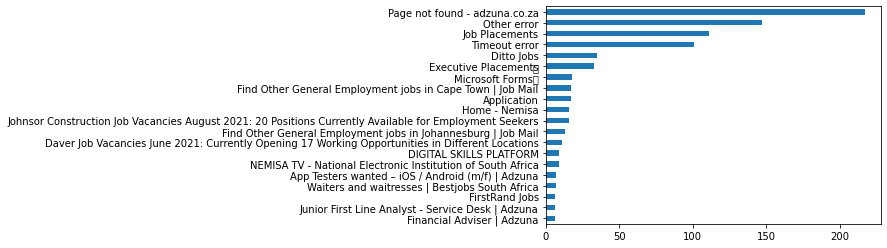

In [191]:
opps_live_clean.title.value_counts()[:20].sort_values().plot(kind = 'barh')